In [10]:
from config import *
import numpy as np
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

pred = glob(f"{RESULT_FOLDER}{os.sep}*.tiff")
labels = glob(f"{ALL_LABELS}{os.sep}*.tiff")

def get_for_names(filenames):
    new_pred = list(filter(lambda x: x.split(os.sep)[-1] in filenames, pred))
    new_labels = list(filter(lambda x: x.split(os.sep)[-1] in filenames, labels))
    assert len(new_pred) == len(new_labels)
    return new_pred, new_labels

valid_labels = glob(f"{V_LABELS}{os.sep}*.tiff")
train_labels = glob(f"{TR_LABELS}{os.sep}*.tiff")

all_files = list(map(lambda x: x.split(os.sep)[-1], labels))
valid_files = list(map(lambda x: x.split(os.sep)[-1], valid_labels))
train_files = list(map(lambda x: x.split(os.sep)[-1], train_labels))

In [3]:
def apply_th(path, th=None):
    img = Image.open(path)
    arr = np.array(img.resize(IMG_SIZE, resample=Image.NEAREST), dtype='float32')
    if th:
        arr[arr >= th] = 1
        arr[arr < th] = 0
    return arr

def get_IoU(pd, gt, smooth=1):
    '''
    pd: label prediction
    gt: label groundtruth
    '''
    i = (pd==1) & (gt==1)
    u = (pd==1) | (gt==1)
    iou = (np.sum(i) + smooth) / (np.sum(u) + smooth)
    return iou

def calc_iou_for_ths(labels, predictions, ths):
    mean_ious = np.repeat(0.0, len(ths))
    for sample in tqdm(range(len(labels))):
        l_arr = apply_th(labels[sample])
        for i, th in enumerate(ths):
            p_arr = apply_th(predictions[sample], th)
            iou = get_IoU(l_arr, p_arr)
            mean_ious[i] += float(iou)
    mean_ious /= len(labels)
    return mean_ious

def plot_iou(labels, predictions, ths):
    ious = calc_iou_for_ths(labels, predictions, ths)
    plt.plot(ths, ious)
    print(f"best th: {ths[np.argmax(ious)]} : {ious[np.argmax(ious)]}")
    return ious

100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 21.09it/s]

best th: 0.74 : 0.516518744062757


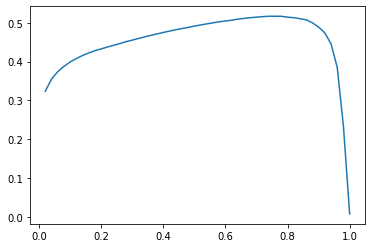

In [5]:
v_pred, v_label = get_for_names(valid_files)
ious = plot_iou(v_label, v_pred, np.arange(0.02, 1.02, 0.02))

100%|████████████████████████████████████████████████████████████████████████████████| 824/824 [00:17<00:00, 47.21it/s]

best th: 0.8700000000000001 : 0.6356699534743624


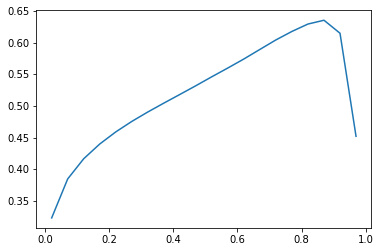

In [11]:
v_pred, v_label = get_for_names(train_files)
ious = plot_iou(v_label, v_pred, np.arange(0.02, 1.02, 0.05))

100%|██████████████████████████████████████████████████████████████████████████████| 9338/9338 [03:14<00:00, 48.09it/s]

best th: 0.9700000000000001 : 0.9001154684915262


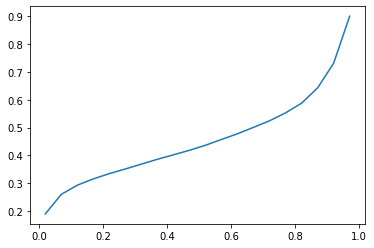

In [12]:
never_seen_files = list(filter(lambda x: x.split(os.sep)[-1] not in train_files, all_files))
n_pred, n_label = get_for_names(never_seen_files)
ious = plot_iou(n_label, n_pred, np.arange(0.02, 1.02, 0.05))